In [1]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            filename, class_id = line.rstrip('\n').split(',')
            res[filename] = int(class_id)
    return res

In [31]:
import sklearn.metrics

y =      np.array([0, 1, 1, 1])
y_pred = np.array([0, 0, 1, 1])

{avr: sklearn.metrics.f1_score(y, y_pred, average=avr) for avr in ["micro", "macro", "weighted", None]}

{'micro': 0.75,
 'macro': 0.7333333333333334,
 'weighted': 0.7666666666666667,
 None: array([0.66666667, 0.8       ])}

In [22]:
tp = 2
tn = 1
fp = 0
fn = 1

pr = tp / (tp + fp)
rc = tp / (tp + fn)

f1_macro = 2 * pr * rc / (pr + rc)

f1_macro

0.8

In [33]:
f10, f11 = sklearn.metrics.f1_score(y, y_pred, average=None)
f10*0.5 + f11*0.5

0.7333333333333334

In [29]:
sklearn.metrics.f1_score(y, y_pred), f1_macro

(0.8, 0.8)

In [4]:
import sys; sys.path.append('../')

import json
import pathlib
import typing as tp

import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import models

from dataset import ImageClassifyDataset
from network import BirdNet


CLASSES_NUM = 50


data_dir = pathlib.Path("./data/00_test_img_input")
output_dir = ""

train_dir = data_dir/'train'
test_dir = data_dir/'test'

train_gt: tp.Dict[str, np.ndarray] = read_csv(train_dir/'gt.csv')
train_img_dir = train_dir/'images'

test_img_dir = test_dir/'images'

# model = train_classifier(train_gt, train_img_dir, fast_train=False)

# model_filename = './facepoints_model.ckpt'
# test_img_dir = test_dir/'images'
# img_classes = classify(model_filename, test_img_dir)
# # save_csv(detected_points, join(output_dir, 'output.csv'))

ModuleNotFoundError: No module named 'base_dataset'

In [3]:
ds = ImageClassifyDataset(CLASSES_NUM, "train", 0.932, train_img_dir, train_gt, new_size=(0, 0))
len(ds)

2330

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

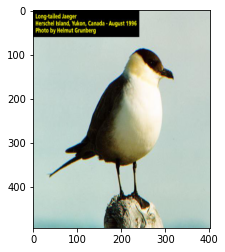

In [4]:
i = 1
plt.imshow(ds[i][0].numpy().transpose(1, 2, 0));
ds[i][1]

In [5]:
with open('./configs/learning_process/base.json') as f:
    learning_process = json.load(f)

In [6]:
dataset_params = learning_process["dataset_params"]
train_fraction = dataset_params["train_fraction"]
if dataset_params["augmentation"] is None:
    transforms = None
else:
    transforms = [
        globals()[dict_["transform_type"]](**dict_["params"])
            for dict_ in dataset_params["augmentation"]
    ]

train_dataset = ImageClassifyDataset(
    classes_num=CLASSES_NUM,
    mode="train",
    train_fraction=train_fraction,
    data_dir=train_img_dir,
    train_gt=train_gt,
    new_size=dataset_params["new_size"],
    transforms=transforms
)

val_dataset = ImageClassifyDataset(
    classes_num=CLASSES_NUM,
    mode="val",
    train_fraction=train_fraction,
    data_dir=train_img_dir,
    train_gt=train_gt,
    new_size=dataset_params["new_size"]
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size = dataset_params["train_batch_size"],
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size = dataset_params["val_batch_size"],
    shuffle=True
)

In [7]:
def create_time_decay(init_lr, intensity):
    def time_decay(epoch):
        lr = init_lr / (1 + intensity * epoch)
        return lr
    return time_decay

In [8]:
loss_params = learning_process["hyper_params"]["loss"]
optimizer_params = learning_process["hyper_params"]["optimizer"]
epoch_nums = learning_process["hyper_params"]["epoch_nums"]

net = BirdNet(
    base_net = models.resnet18(pretrained=True),
    first_layers_number_to_be_frozen = 9
)
loss = getattr(torch.nn, loss_params["loss_type"])(**loss_params["params"])
optimizer = getattr(torch.optim, optimizer_params["optimizer_type"])(
    net.parameters(),
    **optimizer_params["params"]
)
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer, 
#     create_time_decay(
#         init_lr=optimizer_params["params"]["lr"],
#         intensity=0.0
#     ),
#     verbose=True
# )

best_val_loss = float("inf")

In [ ]:
!rm -rf ./runs

# default `log_dir` is "runs".
writer = SummaryWriter('./runs')

for epoch in range(epoch_nums - 1):
    print(f"{epoch=}:")

    net.train()
    loss_history = []
    for X, y, _ in train_dataloader:
        optimizer.zero_grad()
        y_pred = net(X)
        loss_value = loss(y_pred, y)
        loss_value.backward()
        optimizer.step()
        cur_train_loss = loss_value.cpu().data.item()
        loss_history.append(cur_train_loss)
        print("train_loss: %.4f" % cur_train_loss, end='\r')

    train_loss = np.mean(loss_history)
    print("train_loss:\t%.5f" % train_loss)
    
#     scheduler.step()

    net.eval()
    loss_history = []
    eq_history = []
    with torch.no_grad():
        for X, y, shape in val_dataloader:
            shape = shape.numpy()
            y_pred = net(X)
            eq_history.extend(
                list(y_pred.cpu().data.numpy().argmax(axis=1) == y.data.cpu().numpy().argmax(axis=1))
            )
            loss_value = loss(y_pred, y)
            loss_history.append(loss_value.cpu().data.item())

    val_loss = np.mean(loss_history)
    print("val_loss:\t%.5f" % val_loss)
    print("val_accuray:\t%.5f" % np.mean(eq_history))
    
    writer.add_scalars(
        'Loss',
        {
            'train': train_loss,
            'val': val_loss
        },
        epoch
    )
        
    writer.add_scalars(
        'Accuracy',
        {
            'val': np.mean(eq_history)
        },
        epoch
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            },
            pathlib.Path("./birds_model.ckpt")
        )
        print("*")
    print()

writer.close()

epoch=0:
train_loss:	3.95041
val_loss:	3.79251
val_accuray:	0.05200
*

epoch=1:
train_loss:	3.71694
val_loss:	3.61920
val_accuray:	0.08800
*

epoch=2:
train_loss:	3.54179
val_loss:	3.49542
val_accuray:	0.16400
*

epoch=3:
train_loss:	3.37275
val_loss:	3.36163
val_accuray:	0.18000
*

epoch=4:
train_loss:	3.22249
val_loss:	3.19576
val_accuray:	0.24400
*

epoch=5:
train_loss:	3.07425
val_loss:	3.08888
val_accuray:	0.29600
*

epoch=6:
train_loss:	2.94428
val_loss:	2.93961
val_accuray:	0.36400
*

epoch=7:
train_loss:	2.81722
val_loss:	2.82148
val_accuray:	0.39600
*

epoch=8:
train_loss:	2.70684
val_loss:	2.75178
val_accuray:	0.45200
*

epoch=9:
train_loss:	2.59665
val_loss:	2.64024
val_accuray:	0.47200
*

epoch=10:
train_loss:	2.49676
val_loss:	2.56469
val_accuray:	0.52400
*

epoch=11:
train_loss:	2.40014
val_loss:	2.47573
val_accuray:	0.52400
*

epoch=12:
train_loss:	2.31683
val_loss:	2.39050
val_accuray:	0.53200
*

epoch=13:
train_loss:	2.23217
val_loss:	2.31857
val_accuray:	0.54400
*

ep